In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



def build_walk_index(contact_matrix):
    """
    Precompute for each node:
      - neighbors[i]: 1D int array of neighbors
      - cdfs[i]:      1D float array of cumulative probabilities
    """
    N = contact_matrix.shape[0]
    neighbors = [None]*N
    cdfs      = [None]*N

    for i in tqdm(range(N)):
        w = contact_matrix[i]
        idx = np.nonzero(w)[0]
        if idx.size == 0:
            neighbors[i] = np.empty(0, dtype=int)
            cdfs[i]      = np.empty(0, dtype=float)
        else:
            probs = w[idx] / w[idx].sum()
            neighbors[i] = idx
            cdfs[i]      = np.cumsum(probs)
    return neighbors, cdfs






# LOAD CONTACT MATRICES
contact_matrix_zero = np.load('data/hic/wildtype_100kb_zeroed.npy')
# contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed.npy')

# contact_matrix_zero = np.load('data/hic/knockout_100kb_balanced_zeroed.npy')


## Greedy

In [2]:
ttn_clique_greedy = cf.find_greedy_clique(contact_matrix=contact_matrix_zero, n=5, target_bin=TTN_BIN)

In [3]:
ttn_clique_greedy

[4275, 30478, 25137, 30357, 29661]

In [48]:
import networkx as nx
import matplotlib.pyplot as plt

def clique_to_graph(contact_matrix, clique, selected_bin=None):
    
    edges = []
    for i in range(len(clique)):
        for j in range(i+1, len(clique)):
            edges.append((clique[i], clique[j], contact_matrix[clique[i], clique[j]]))

    G = nx.Graph()
    G.add_nodes_from(clique)
    G.add_weighted_edges_from(edges)
    node_colors = ['red' if bin == selected_bin else 'skyblue' for bin in clique]

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors,
            font_size=10, font_weight='bold', edge_color='gray')

    labels = nx.get_edge_attributes(G, 'weight')
    labels = {k: f"{v:.5f}" for k, v in labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12, font_weight='bold')

    plt.tight_layout()
    plt.show()
    return G

/scratch/eoutangoun/job_39717051/ipykernel_3183460/3292079702.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


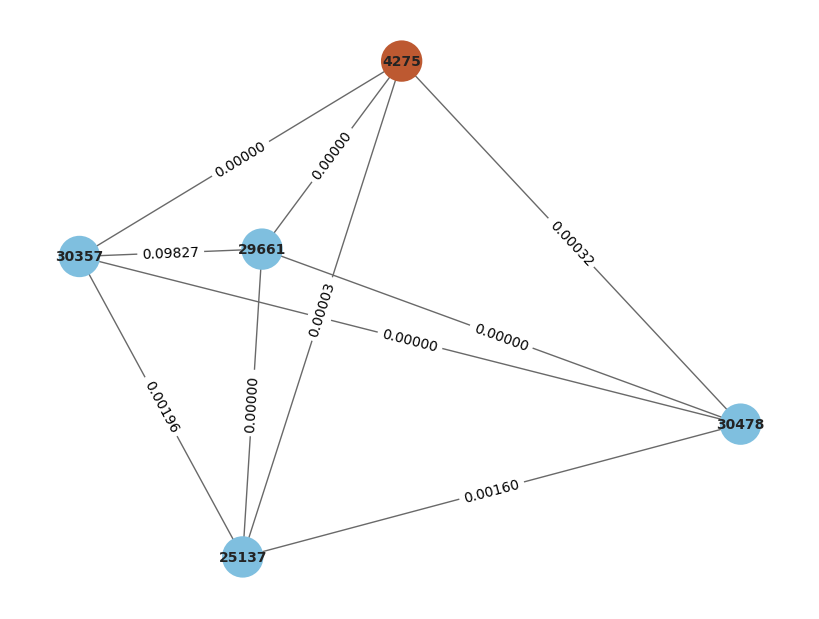

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def clique_to_graph(contact_matrix, clique, selected_bin=None):
    
    edges = []
    for i in range(len(clique)):
        for j in range(i+1, len(clique)):
            edges.append((clique[i], clique[j], contact_matrix[clique[i], clique[j]]))

    G = nx.Graph()
    G.add_nodes_from(clique)
    G.add_weighted_edges_from(edges)

    base_color = '#7fbfdf'    
    highlight_color = "#bd5931" 
    node_colors = [highlight_color if bin == selected_bin else base_color for bin in clique]

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=800, node_color=node_colors,
            font_size=10, font_weight='bold', edge_color='dimgray', linewidths=1.5, font_color="#232323")

    labels = nx.get_edge_attributes(G, 'weight')
    labels = {k: f"{v:.5f}" for k, v in labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10)

    plt.tight_layout()
    plt.show()
    return G

clique_to_graph(contact_matrix_zero, ttn_clique_greedy, selected_bin=TTN_BIN)

In [5]:
core.stats.calculate_avg_interaction_strength(contact_matrix_zero, ttn_clique_greedy)

0.010217975885194035

## Diffusion

In [6]:
ttn_clique_diffusion, visits = cf.analytical_diffusion_clique(contact_matrix=contact_matrix_zero, start_node=TTN_BIN, n=11, alpha=0.25)

# save visits
np.save("ttn_visits_diffusion_alpha_0.25_.npy", visits)

/scratch/eoutangoun/job_39717051/ipykernel_3183460/3292079702.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


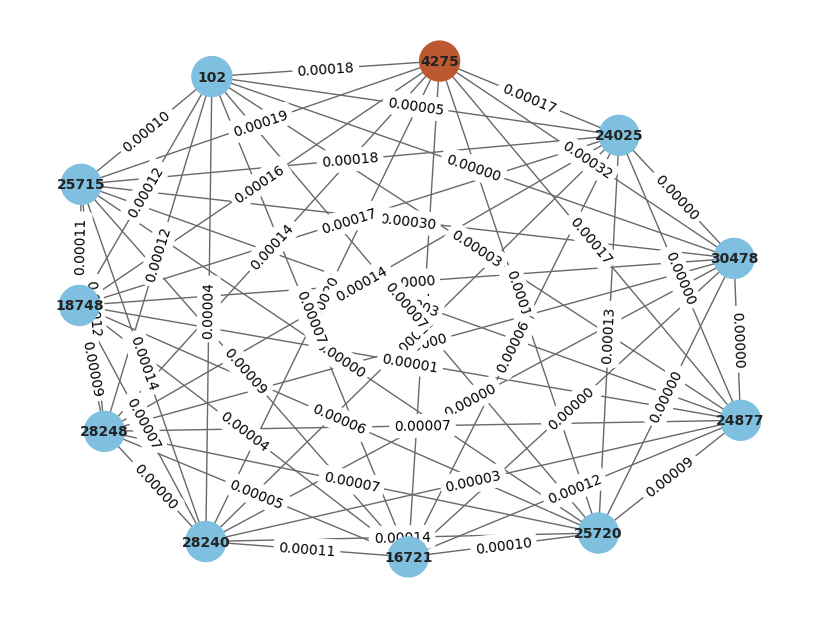

In [7]:
# Create a graph from the clique
clique_to_graph(contact_matrix_zero, ttn_clique_diffusion, selected_bin=TTN_BIN)